# Mini-proyecto de Computer Vision (OpenCV): *lectura didáctica* de una matrícula UK (amarilla) sin OCR

> **Objetivo didáctico**: construir un pipeline que combine varias técnicas clásicas de CV, **sin pretender ser perfecto**, para:
1. Cargar una imagen (local o URL) con la **parte trasera de un coche** y una **matrícula UK amarilla**.
2. **Normalizar** valores (0–1) y **redimensionar** la imagen.
3. Usar **K-Means** sobre píxeles para quedarnos con la región **amarilla** (matrícula + ruido).
4. **Binarizar** y aplicar **morfología** (erode/dilate) para limpiar.
5. Localizar la **caja de la matrícula** con **proyecciones** (sumas por fila/columna).
6. Segmentar cada **carácter** con la misma idea (proyección vertical).
7. Reconocer cada carácter por **comparación con plantillas** (*template matching*).
8. Devolver la predicción final.

---

## ⚠️ Aviso importante (ético y práctico)
- Usa imágenes **propias** o con derechos adecuados (o datasets educativos).
- Este notebook es **para aprender** técnicas, no para desplegar un sistema robusto en producción.

---

## Requisitos
- `opencv-python`
- `numpy`
- `matplotlib`
- (opcional) `requests` para cargar desde URL

In [1]:
# Si estás en Colab / entorno limpio:
# !pip -q install opencv-python matplotlib requests

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Opcional para URLs
import requests
from io import BytesIO

In [2]:
# --- Configuración de entrada ---
USE_URL = True

# URL por defecto (Wikimedia Commons). Si falla, pon USE_URL=False y usa ruta local.
IMAGE_URL = "https://cdn.warrantywise.co.uk/wp-content/uploads/2020/09/03115906/The-New-70-Plate-Registration-Has-Launched-Cover-Photo.jpg.webp"
LOCAL_PATH = None

In [3]:
def load_image_bgr(use_url=True, image_url=None, local_path=None):
    """Carga una imagen en BGR (formato OpenCV), desde URL o disco."""
    if use_url:
        if not image_url:
            raise ValueError("Falta IMAGE_URL")
        r = requests.get(image_url, timeout=30)
        r.raise_for_status()
        img_arr = np.frombuffer(r.content, dtype=np.uint8)
        img = cv2.imdecode(img_arr, cv2.IMREAD_COLOR)
        if img is None:
            raise ValueError("No se pudo decodificar la imagen desde URL.")
        return img
    else:
        if not local_path:
            raise ValueError("Falta LOCAL_PATH")
        img = cv2.imread(local_path, cv2.IMREAD_COLOR)
        if img is None:
            raise ValueError(f"No se pudo leer la imagen: {local_path}")
        return img

img_bgr = load_image_bgr(USE_URL, IMAGE_URL, LOCAL_PATH)

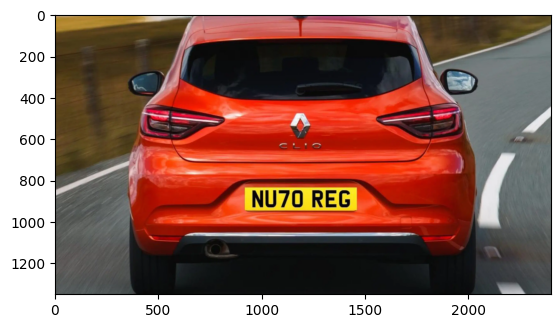

In [4]:
plt.imshow(img_bgr[:, :, [2,1,0]]);

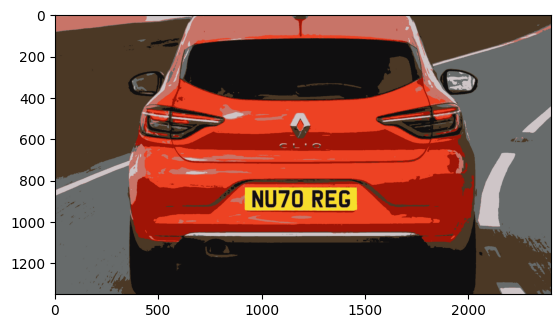

Cluster centers:
Cluster 0: [103 107 107]
Cluster 1: [246 222  43]
Cluster 2: [16 15 16]
Cluster 3: [206 197 199]
Cluster 4: [159  20   6]
Cluster 5: [75 56 37]
Cluster 6: [200 116 104]
Cluster 7: [237  66  35]


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Reshape and convert to float32
pixel_vals = image.reshape((-1, 3))
pixel_vals = np.float32(pixel_vals)

# Apply K-Means
k = 8  # Number of clusters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Reconstruct and Reshape
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
segmented_image = segmented_data.reshape((image.shape))

# Show img
plt.imshow(segmented_image)
plt.show()

# Print clusters
print("Cluster centers:")
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

In [6]:
yellow = [250, 250, 20]  # define yellow RGB

distances = np.sum((centers - yellow) ** 2, axis=1)  # euclidean distance formula
yellow_index = np.argmin(distances)  # index with smallest value (distance)

print("Yellow cluster:")
print(f"Cluster {yellow_index}: {centers[yellow_index]}")

Yellow cluster:
Cluster 1: [246 222  43]


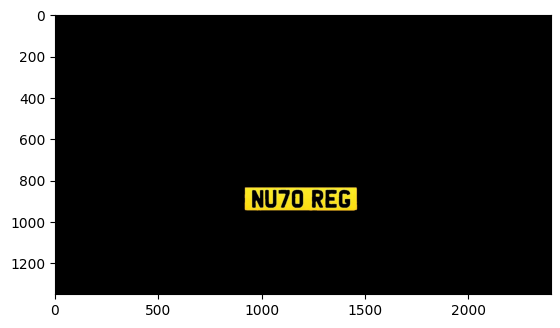

In [7]:
# copy the image
masked_img = np.copy(image)

# create a mask for the yellow cluster
mask = (labels.reshape(image.shape[:2]) != yellow_index)  # for all clusters that aren't yellow
masked_img[mask] = [0, 0, 0]  # set all the other clusters to black

plt.imshow(masked_img)
plt.show()

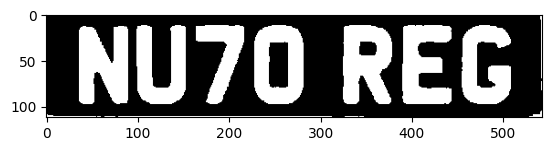

In [24]:
#We turn the image into gray scale
gray = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)

#We classify every pixel with a value of 0 in the gray scale as black
line, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

#We locate the non zero pixels, meaning the non black ones, and their coords
coords = cv2.findNonZero(thresh)
x, y, w, h = cv2.boundingRect(coords)

#We use those coords to trim the area we want (where the non black pixels are, meaning where the plate is)
exp_img = thresh[y:y+h, x:x+w]
new = 255 - exp_img  #switch the black and white to have white letters

#We show the expanded plate
plt.imshow(new, cmap="gray")
plt.show()

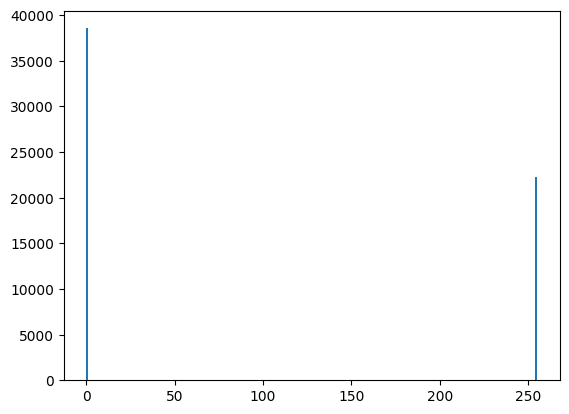

In [25]:
plt.hist(new.ravel(), bins=252);

# TEMPLATES

In [8]:
TEMPLATE_H = 45
TEMPLATE_W = 33

ALPHABET = list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ")

def make_template(char, w=TEMPLATE_W, h=TEMPLATE_H):
    img = np.zeros((h, w), dtype=np.uint8)
    # Fuente Hershey; probamos una combinación que suele verse "placa"
    font = cv2.FONT_HERSHEY_SIMPLEX  
    scale = 1.8
    thickness = 5

    # Centramos el texto
    (tw, th), baseline = cv2.getTextSize(char, font, scale, thickness)
    x = 2+(w - tw) // 2
    y = -2 + (h + th) // 2
    cv2.putText(img, char, (x, y), font, scale, 255, thickness, cv2.LINE_AA)

    # Opcional: pequeña dilatación para engordar un pelín
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    img = cv2.dilate(img, k, iterations=1)

    return img

templates = {ch: make_template(ch) for ch in ALPHABET}
